# PREDATOR: **PRED**icting the imp**A**ct of cancer somatic mu**T**ations on pr**O**tein-protein inte**R**actions


## Model Development: Training Only


<b><i class="fa fa-folder-o" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Location</b><br>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">C:\Users\ibrah\Documents\GitHub\Predicting-Mutation-Effects\src</code>
</p>

<b><i class="far fa-file" area-hidden="true" style="color:#1976D2"> </i>&nbsp; File Name</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">PredatorStudyModel.ipynb</code>
</p>

<b><i class="far fa-calendar-alt" area-hidden="true" style="color:#1976D2"> </i>&nbsp; Last Edited</b>
<p style="background:#F5F5F5; text-indent: 1em;">
<code style="background:#F5F5F5; color:#404040; font-weight:bold; font-size:12px">October 15th, 2021</code>
</p>


<div class="alert alert-block" style="background-color: #F5F5F5; border: 1px solid; padding: 10px; border-color: #E0E0E0">
    <b><i class="fa fa-compass" aria-hidden="true" style="color:#404040"></i></b>&nbsp; <b style="color: #404040">Purpose </b> <br>
<div>

    
- [x] $\textit{mutation effect label}$ prediction using Random Forest algorithm.
    

- [x] Classification will be $\textit{Disrupting vs (No effect + Increasing)}$.
    > $\textit{Disrupting} → 0$\
    > $\textit{No effect + Increasing} → 1$\
    > $\textit{Decreasing} → \textit{ignored}$
    
    
- [x] Evaluate the performane of the model.
    
- [x] We use SHAP in feature selection
     
- [x] We measure the impact of randomization by repeating whole experiment with multiple runs. 
    
- [x] We use Predator object to conduct experiments.
    
**Dependent files:**
* Training (mutations) data:
    - *training_data_M1.txt*

In [1]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import random
from pathlib import Path

from pprint import pprint
from IPython.display import display
from tqdm.notebook import tqdm

from helpers.helpers_predator.displayers import (
    display_label_counts, 
    display_labels, 
    visualize_label_counts,
    display_data,
)
from helpers.helpers_predator.visualizers import (
    visualize_sampled_train_datasets_label_counts
)

NUM_EXPERIMENT_REPEAT = 50 # 10, 25, 50

SEED = 42
random.seed(SEED)
random_seeds = random.sample(range(1, 99999), NUM_EXPERIMENT_REPEAT)

# PATHS
PROJECT_COMMON_FILE_DIR = "../data/"
MUTATIONS_PATH = "training_data_M1.txt"
INITIAL_COLUMNS_PATH = "../data/initial_columns_59.csv"

# Reflect changes in the modules immediately.
%load_ext autoreload
%autoreload 2

In [2]:
from Predator import Predator

In [3]:
predator = Predator(
    project_common_file_dir=PROJECT_COMMON_FILE_DIR, 
    mutations_path=MUTATIONS_PATH, 
    initial_columns_path=INITIAL_COLUMNS_PATH, 
    n_experiment=NUM_EXPERIMENT_REPEAT,
    eliminate_models=True
)

2021-10-15 23:05:37 | DEBUG    | Predator | Initializing Predator ..
2021-10-15 23:05:37 | DEBUG    | helpers.helpers_predator.data_materials | Initialize `train_data` ..
2021-10-15 23:05:37 | DEBUG    | helpers.helpers_predator.data_materials | Initialize `train_data_processed` ..


## Datasets

### Original Datasets

#### 1. Training Data: Mutations

In [4]:
display_data(predator.data_materials["train_data"])

Data dimensions: (1101, 104)


,Mutation_Effect_Label,Input_identifier,UniProt_ID,Mutation,Status,Type,COSMIC_mut_ID,ClinVar_mut_ID,UniProt_mut_ID,Domain_name,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
1,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627
2,mutation decreasing rate(MI:1130),P63000,P63000,Q61L,done,interface,-,-,-,Ras,...,378.0,40.0165,40.2638,61.9441,61.9441,None,None,None,3.7681,3.21627


### Processed Datasets

#### 1. Preprocessed Training Data 

In [5]:
display_data(predator.data_materials["train_data_processed"])

Data dimensions: (740, 62)


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.21970,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.07695,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,F534D,Q9UBQ0,1.0000,0.360743,1.0000,0.994505,2.69571,0.288297,...,453.0,68.21080,68.19710,59.2321,59.1774,510.690,298.820,809.510,3.03938,3.24435


Label counts:
Disrupting                540
Increasing + No Effect    200
Name: Mutation_Effect_Label, dtype: int64


,Mutation_Effect_Label,Counts
Disrupting,0,540
Increasing + No Effect,1,200


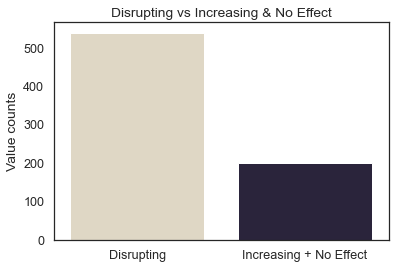

In [6]:
visualize_label_counts(predator.data_materials["train_data_processed"])
display_label_counts(predator.data_materials["train_data_processed"])

## Data Sampling with Unique Proteins

In [7]:
predator.sample_spsm()

2021-10-15 23:05:38 | DEBUG    | Predator | sampling ..


  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list'])

In [9]:
display_data(predator.data_materials["sampled_train_data_list"][0], head_row=5)

Data dimensions: (164, 62)


,Mutation_Effect_Label,UniProt_ID,Mutation,Interactor_UniProt_ID,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,0,Q9BPZ3,F118A,P11940,1.0000,1.000000,1.0000,0.968750,1.219700,-0.092273,...,118.0,5.30636,3.79101,52.4675,52.4675,427.775,194.715,622.495,3.35293,3.35293
1,0,P01116,Y40C,P50749,0.9277,0.931315,0.3553,0.172500,2.076950,0.998749,...,329.0,47.61770,47.21160,70.2902,70.2461,464.470,400.030,864.505,3.07827,3.59123
2,0,Q96QK1,T629D,Q9UBQ0-2,1.0000,0.360743,1.0000,0.973118,1.252190,0.403159,...,453.0,68.34290,68.21480,59.2629,59.2629,510.690,298.820,809.510,4.36339,4.34314
3,0,O43521-3,G66E,P10415-2,1.0000,0.714286,0.6505,0.435452,1.866070,-0.076393,...,181.0,2.15789,3.50531,30.7415,30.7626,421.875,272.215,694.090,3.41921,1.76365
4,1,Q13418,Q362H,Q9NVD7,0.9925,0.971054,1.0000,0.961240,0.621791,0.206189,...,391.0,60.07690,60.06430,33.8017,33.8017,406.135,174.195,580.330,3.39874,3.39874


In [10]:
# Number of sampled train data
len(predator.data_materials["sampled_train_data_list"])

50

### Label Distributions in Training Data

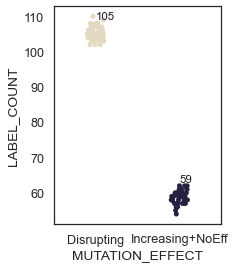

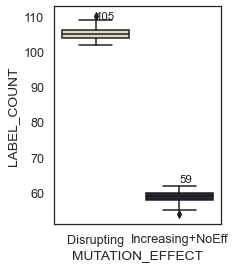

In [11]:
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='strip')
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='box')

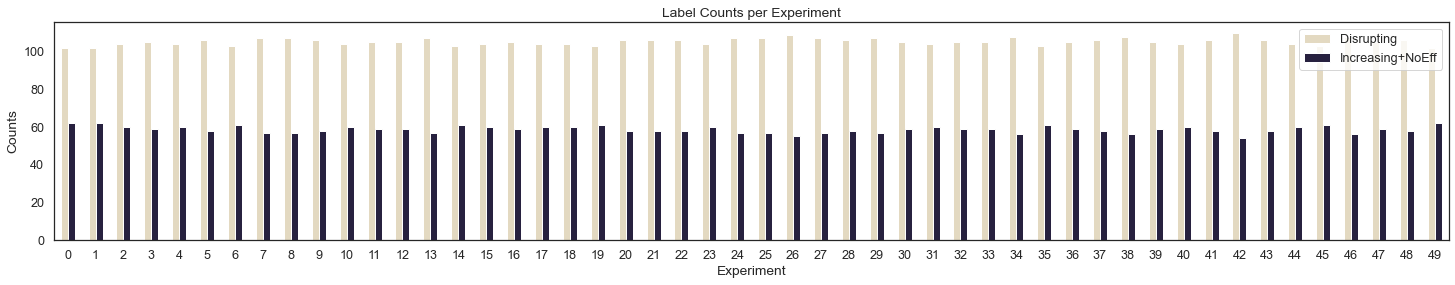

In [12]:
visualize_sampled_train_datasets_label_counts(predator.data_materials["sampled_train_data_list"], kind='bar')

## Preparing the Train Data Materials for Machine Learning Algorithms

In [13]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list'])

In [14]:
predator.data_materials.prepare_model_data_materials()  # it will initialize Xs etc. too

2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | preparing datasets for ML ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Initializing model datasets ..


  0%|          | 0/50 [00:00<?, ?it/s]

2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials | Appending data materials ..
2021-10-15 23:05:52 | DEBUG    | helpers.helpers_predator.data_materials 

In [15]:
print(len(predator.data_materials["Xs"]))
predator.data_materials["Xs"][0].head()

50


,Template_sequence_identity,Alignment_score,Interactor_template_sequence_identity,Interactor_alignment_score,Final_ddG,ProtBert_score,ProteinSolver_score,EL2_score,Model/DOPE_score,Provean_score,...,number_of_residues_mut,IntraclashesEnergy1_wt,IntraclashesEnergy1_mut,IntraclashesEnergy2_wt,IntraclashesEnergy2_mut,Interface_hydrophobic_area,Interface_hydrophilic_area,Interface_total_area,Interface_contact_distance_wt,Interface_contact_distance_mut
0,1.0000,0.483871,0.9930,0.863124,5.977720,-0.103788,0.841449,1.551375,-0.805142,-8.790,...,316.0,8.64833,8.63232,90.3947,89.1921,524.985,258.980,783.96,2.46202,2.98422
1,1.0000,1.000000,0.4167,0.372027,1.700660,-0.116186,0.028181,-0.446740,0.127684,-7.998,...,249.0,27.72640,27.86500,139.5970,139.5970,386.025,245.065,631.09,3.57046,3.48332
2,0.6803,0.517968,0.4645,0.481888,0.937272,0.058100,0.165439,-0.028320,1.569780,-3.628,...,318.0,293.43500,294.70400,45.8003,45.8003,716.790,358.840,1075.62,4.33509,4.33509
3,0.9945,0.975130,0.9939,0.906319,1.511710,0.994536,0.171553,1.875893,-0.410594,-6.333,...,712.0,200.85600,199.44300,62.1484,62.1484,267.500,155.585,423.08,3.07379,3.07379
4,0.9032,0.902219,0.8519,0.838599,1.414480,0.156140,0.500075,1.100519,0.299283,-5.300,...,236.0,49.67150,48.43100,23.9715,23.9715,176.945,115.630,292.58,2.94553,5.48003


## Initial Insights

For each experiment, the models are fitted with 80% of training data and predictions are made for the remaining 20%. Then performance is evaluated comparing predictions with groundtruth labels.

In [16]:
predator.run_evaluate_valid(models_type='default')

2021-10-15 23:05:53 | DEBUG    | helpers.helpers_predator.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-10-15 23:05:53 | DEBUG    | helpers.helpers_predator.evaluation | Evaluating with default models.


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.6667
Balanced accuracy score : 0.5952
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6190
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6548
-------- EXPERIMENT:  4 --------
X_train.shape=(131, 58), y_train.shape=(131,), X_valid.shape=(33, 58), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.6970
Balanced accuracy score : 0.6012
-------- EXPERIMENT:  5 --------
X_train.shape=(131, 58), y_trai

In [17]:
from helpers.helpers_predator.visualizers import visualize_accuracy_metrics

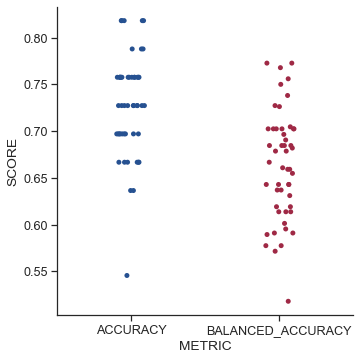

In [18]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["initial_scoring"]["acc_scores"], 
    predator.eval_valid.scores["initial_scoring"]["balan_acc_scores"],
    kind='strip'
)

## SHAP Feature Importance Ranking

In [19]:
# shap_top_ns = [10, 20]
shap_top_ns = [5, 10, 20, 30, 40]

In [20]:
predator.init_shap_feature_selector(shap_top_ns)

2021-10-15 23:06:06 | DEBUG    | helpers.helpers_predator.feature_selection | Initializing ShapFeatureSelector ..


2021-10-15 23:06:06 | DEBUG    | helpers.helpers_predator.feature_selection | Loading ShapFeatureSelector ..


  0%|          | 0/50 [00:00<?, ?it/s]

 === SELECTED FEATURES === 
 --- SHAP TOP 5 ---
Experiment 1
['Provean_score', 'EL2_score', 'Matrix_score', 'electrostatics_mut', 'Final_ddG']

Experiment 2
['Provean_score', 'EL2_score', 'Final_ddG', 'solvation_polar_wt', 'entropy_mainchain_wt']

Experiment 3
['EL2_score', 'Final_ddG', 'Provean_score', 'Interface_contact_distance_mut', 'Interface_contact_distance_wt']

Experiment 4
['EL2_score', 'Provean_score', 'Final_ddG', 'Interface_contact_distance_mut', 'entropy_sidechain_mut']

Experiment 5
['EL2_score', 'Provean_score', 'Final_ddG', 'sidechain_hbond_mut', 'Solvent_accessibility_wt']

Experiment 6
['Final_ddG', 'EL2_score', 'Provean_score', 'solvation_polar_mut', 'solvation_polar_wt']

Experiment 7
['EL2_score', 'Provean_score', 'Final_ddG', 'Matrix_score', 'electrostatics_mut']

Experiment 8
['EL2_score', 'Provean_score', 'Final_ddG', 'Solvent_accessibility_mut', 'pcv_vdW_self_wt']

Experiment 9
['Provean_score', 'EL2_score', 'Final_ddG', 'Matrix_score', 'ProteinSolver_score']


## Aggregated Feature Selection

In [21]:
predator.aggregate_selected_features('occurrence')

2021-10-15 23:06:18 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=5]..
2021-10-15 23:06:18 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=10]..
2021-10-15 23:06:19 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=20]..
2021-10-15 23:06:19 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=30]..
2021-10-15 23:06:19 | DEBUG    | helpers.helpers_predator.data_materials | Initialize feature selected data materials [n_top=40]..


In [22]:
predator.shap_feature_selector.aggregated_feature_selector.n_features_to_selected_features_occurrences_counts

defaultdict(dict,
            {5: defaultdict(int,
                         {'Provean_score': 49,
                          'EL2_score': 50,
                          'Matrix_score': 22,
                          'electrostatics_mut': 2,
                          'Final_ddG': 46,
                          'solvation_polar_wt': 4,
                          'entropy_mainchain_wt': 3,
                          'Interface_contact_distance_mut': 5,
                          'Interface_contact_distance_wt': 1,
                          'entropy_sidechain_mut': 1,
                          'sidechain_hbond_mut': 1,
                          'Solvent_accessibility_wt': 8,
                          'solvation_polar_mut': 3,
                          'Solvent_accessibility_mut': 9,
                          'pcv_vdW_self_wt': 1,
                          'ProteinSolver_score': 2,
                          'Interactor_alignment_score': 22,
                          'entropy_sidechain_wt': 3,
    

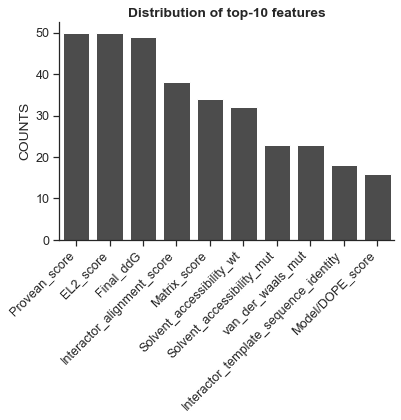

In [23]:
from helpers.helpers_predator.visualizers import visualize_distribution_top_n_features

visualize_distribution_top_n_features(predator.shap_feature_selector, 10)  # available for each shap_top_ns.

In [24]:
predator.shap_feature_selector.n_features_to_aggregated_features[10]

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

In [25]:
predator.shap_feature_selector.display_rankings(10, extract=True)

2021-10-15 23:06:20 | DEBUG    | helpers.helpers_predator.feature_selection | Displaying rankings ..
2021-10-15 23:06:20 | DEBUG    | helpers.helpers_predator.feature_selection | Extracting rankings ..
2021-10-15 23:06:20 | INFO     | helpers.helpers_predator.feature_selection | Rankings are extracted to file rankings_10.csv.


,0,1,2,3,4,5,6,7,8,9
0,Provean_score,EL2_score,Matrix_score,electrostatics_mut,Final_ddG,Interactor_alignment_score,Solvent_accessibility_mut,Model/DOPE_score,van_der_waals_mut,pcv_vdW_self_wt
1,Provean_score,EL2_score,Final_ddG,solvation_polar_wt,entropy_mainchain_wt,sidechain_hbond_mut,Solvent_accessibility_mut,Solvent_accessibility_wt,van_der_waals_mut,Model/DOPE_score
2,EL2_score,Final_ddG,Provean_score,Interface_contact_distance_mut,Interface_contact_distance_wt,entropy_sidechain_wt,Solvent_accessibility_mut,entropy_sidechain_mut,pcv_vdW_wt,Interactor_alignment_score
3,EL2_score,Provean_score,Final_ddG,Interface_contact_distance_mut,entropy_sidechain_mut,Interactor_template_sequence_identity,van_der_waals_mut,Interface_contact_distance_wt,sidechain_hbond_wt,Model/DOPE_score
4,EL2_score,Provean_score,Final_ddG,sidechain_hbond_mut,Solvent_accessibility_wt,Matrix_score,entropy_sidechain_mut,entropy_sidechain_wt,sidechain_hbond_wt,Interactor_template_sequence_identity


In [26]:
predator.shap_feature_selector.n_features_to_aggregated_features

{5: ['EL2_score',
  'Provean_score',
  'Final_ddG',
  'Matrix_score',
  'Interactor_alignment_score'],
 10: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'Matrix_score',
  'Solvent_accessibility_wt',
  'Solvent_accessibility_mut',
  'van_der_waals_mut',
  'Interactor_template_sequence_identity',
  'Model/DOPE_score'],
 20: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'van_der_waals_mut',
  'Matrix_score',
  'Solvent_accessibility_wt',
  'Solvent_accessibility_mut',
  'Interactor_template_sequence_identity',
  'Model/DOPE_score',
  'entropy_sidechain_mut',
  'electrostatics_mut',
  'ProteinSolver_score',
  'ProtBert_score',
  'solvation_polar_wt',
  'entropy_mainchain_wt',
  'solvation_polar_mut',
  'entropy_sidechain_wt',
  'pcv_vdW_self_wt',
  'Interface_contact_distance_mut'],
 30: ['Provean_score',
  'EL2_score',
  'Final_ddG',
  'Interactor_alignment_score',
  'van_der_waals_mut',
  'Solvent_accessibility_wt',

In [27]:
predator.shap_feature_selector.n_features_to_aggregated_features[10]

['Provean_score',
 'EL2_score',
 'Final_ddG',
 'Interactor_alignment_score',
 'Matrix_score',
 'Solvent_accessibility_wt',
 'Solvent_accessibility_mut',
 'van_der_waals_mut',
 'Interactor_template_sequence_identity',
 'Model/DOPE_score']

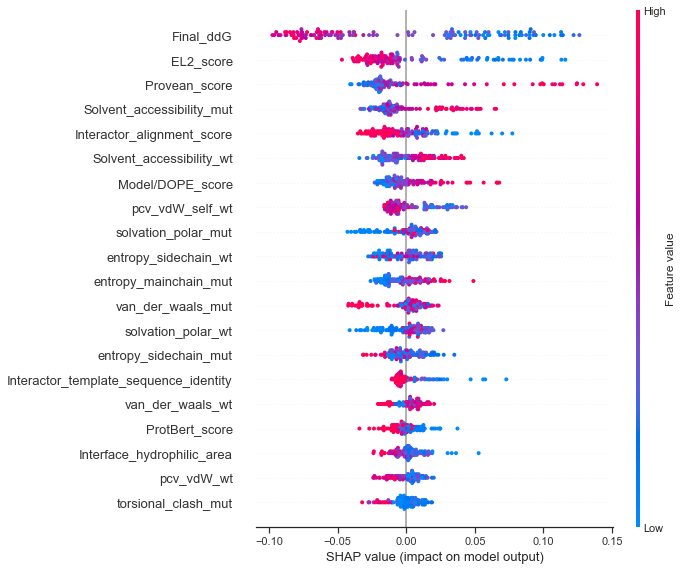

In [28]:
# TODO: convert a function in predator.py
import shap

shap.summary_plot(predator.shap_feature_selector.shap_values_train_list[38][1], 
                  predator.data_materials["Xs_train"][38])

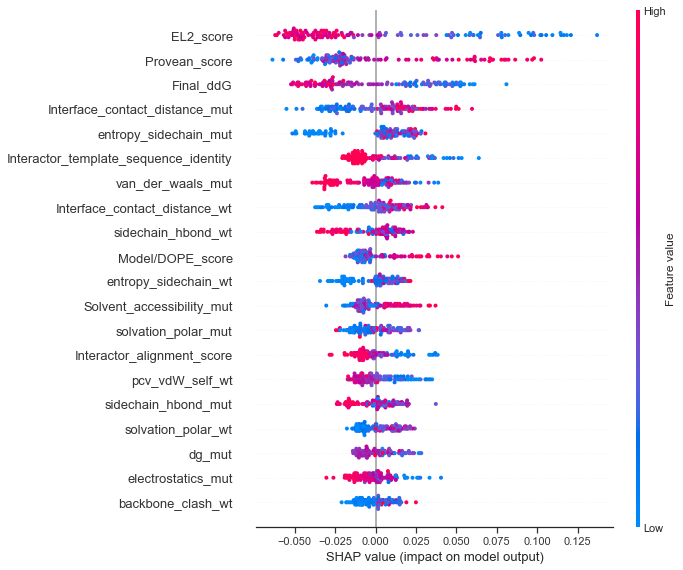

In [29]:
shap.summary_plot(predator.shap_feature_selector.shap_values_train_list[3][1], 
                  predator.data_materials["Xs_train"][3])

## Evaluation Metrics

In [30]:
from helpers.helpers_predator.evaluation import evaluate_metrics

In [31]:
predator.initialize_evaluation_metrics()

2021-10-15 23:06:23 | INFO     | helpers.helpers_predator.evaluation | Initializing EvaluationMetrics..
2021-10-15 23:06:23 | INFO     | helpers.helpers_predator.evaluation | Initialize_benchmark_dataframes ..


<div class="alert alert-block" style="background-color: white; border: 2px solid; padding: 10px; border-color: #F57C00">
    <b style="color: #F57C00"><i class="fa fa-warning" aria-hidden="true"></i>&nbsp; Warning</b><br>
<div>
    
Evaluation will take a long time.

In [35]:
raise

RuntimeError: No active exception to reraise

In [62]:
predator.eval_metrics.run_eval_metrics(n_repeats=1, n_jobs=-1, verbose=True)
# todo
# predator.run_evaluation_metrics(n_repeats=5, n_jobs=4, verbose=True)

2021-10-16 20:37:04 | INFO     | helpers.helpers_predator.evaluation | Running evaluation metrics ..


  0%|          | 0/50 [00:00<?, ?it/s]


EVALUATION METRIC: F1
------------------------------------
X_train_exp_0_provean       : 0.4761
X_train_exp_0_ddG           : 0.4335
X_train_exp_0               : 0.5559
X_train_exp_0_shap_5        : 0.5007
X_train_exp_0_shap_10       : 0.5425
X_train_exp_0_shap_20       : 0.5459
X_train_exp_0_shap_30       : 0.5657
X_train_exp_0_shap_40       : 0.5711

EVALUATION METRIC: BALANCED_ACCURACY
------------------------------------
X_train_exp_0_provean       : 0.5915
X_train_exp_0_ddG           : 0.5778
X_train_exp_0               : 0.6625
X_train_exp_0_shap_5        : 0.6701
X_train_exp_0_shap_10       : 0.6846
X_train_exp_0_shap_20       : 0.715
X_train_exp_0_shap_30       : 0.6769
X_train_exp_0_shap_40       : 0.6594

EVALUATION METRIC: ACCURACY
------------------------------------
X_train_exp_0_provean       : 0.6033
X_train_exp_0_ddG           : 0.5714
X_train_exp_0               : 0.7319
X_train_exp_0_shap_5        : 0.672
X_train_exp_0_shap_10       : 0.7341
X_train_exp_0_shap_20   

KeyboardInterrupt: 

In [32]:
predator.eval_metrics.scoring_metrics_data

,Provean,$\Delta\Delta$G,All Columns,SHAP Columns (5),SHAP Columns (10),SHAP Columns (20),SHAP Columns (30),SHAP Columns (40)
METRIC,,,,,,,,
accuracy,0.608608,0.593184,0.708554,0.718434,0.731824,0.732954,0.721760,0.721516
balanced_accuracy,0.584584,0.558856,0.649188,0.664852,0.682868,0.678764,0.665382,0.662216
f1,0.460978,0.408260,0.499036,0.529504,0.552406,0.540436,0.520012,0.506262
f1_macro,0.575592,0.550896,0.638540,0.660010,0.682670,0.677280,0.660832,0.652216
f1_micro,0.610918,0.592438,0.714802,0.708570,0.733240,0.734074,0.723942,0.721238
precision,0.467904,0.440274,0.664276,0.646692,0.690770,0.689324,0.677932,0.692092
precision_macro,0.585990,0.557632,0.709276,0.706228,0.725778,0.729258,0.718124,0.709596
precision_micro,0.611756,0.592080,0.719038,0.713898,0.729724,0.733362,0.727814,0.717522
recall,0.482200,0.433100,0.415500,0.497500,0.503700,0.480800,0.465600,0.437800


|                   |  Provean |      $\Delta\Delta$G | All Columns | SHAP Columns (5) | SHAP Columns (10) | SHAP Columns (20) | SHAP Columns (30) | SHAP Columns (40) |
|------------------:|---------:|---------:|------------:|-----------------:|------------------:|------------------:|------------------:|------------------:|
|          **accuracy** | 0.610760 | 0.593208 |    0.714452 |         0.709600 |          0.731082 |          0.730880 |          0.723732 |          0.721166 |
| **balanced_accuracy** | 0.581348 | 0.553346 |    0.646770 |         0.658926 |          0.684346 |          0.680468 |          0.667830 |          0.660290 |
|                **f1** | 0.457686 | 0.419508 |    0.488514 |         0.524742 |          0.548794 |          0.547668 |          0.527700 |          0.505250 |
|          **f1_macro** | 0.571148 | 0.546018 |    0.636866 |         0.660598 |          0.679270 |          0.676998 |          0.659292 |          0.654624 |
|          **f1_micro** | 0.614980 | 0.589080 |    0.711412 |         0.717540 |          0.732424 |          0.733220 |          0.726720 |          0.721122 |
|         **precision** | 0.474758 | 0.432868 |    0.671394 |         0.652346 |          0.688832 |          0.693074 |          0.673812 |          0.669226 |
|   **precision_macro** | 0.595020 | 0.560870 |    0.696782 |         0.703838 |          0.721984 |          0.737650 |          0.722108 |          0.710566 |
|   **precision_micro** | 0.612284 | 0.595524 |    0.713366 |         0.715992 |          0.734674 |          0.735460 |          0.726382 |          0.720640 |
|            **recall** | 0.479600 | 0.428800 |    0.414700 |         0.494300 |          0.506600 |          0.485700 |          0.469800 |          0.429400 |
|           **roc_auc** | 0.636772 | 0.609460 |    0.738156 |         0.745736 |          0.763738 |          0.762828 |          0.758032 |          0.752386 |

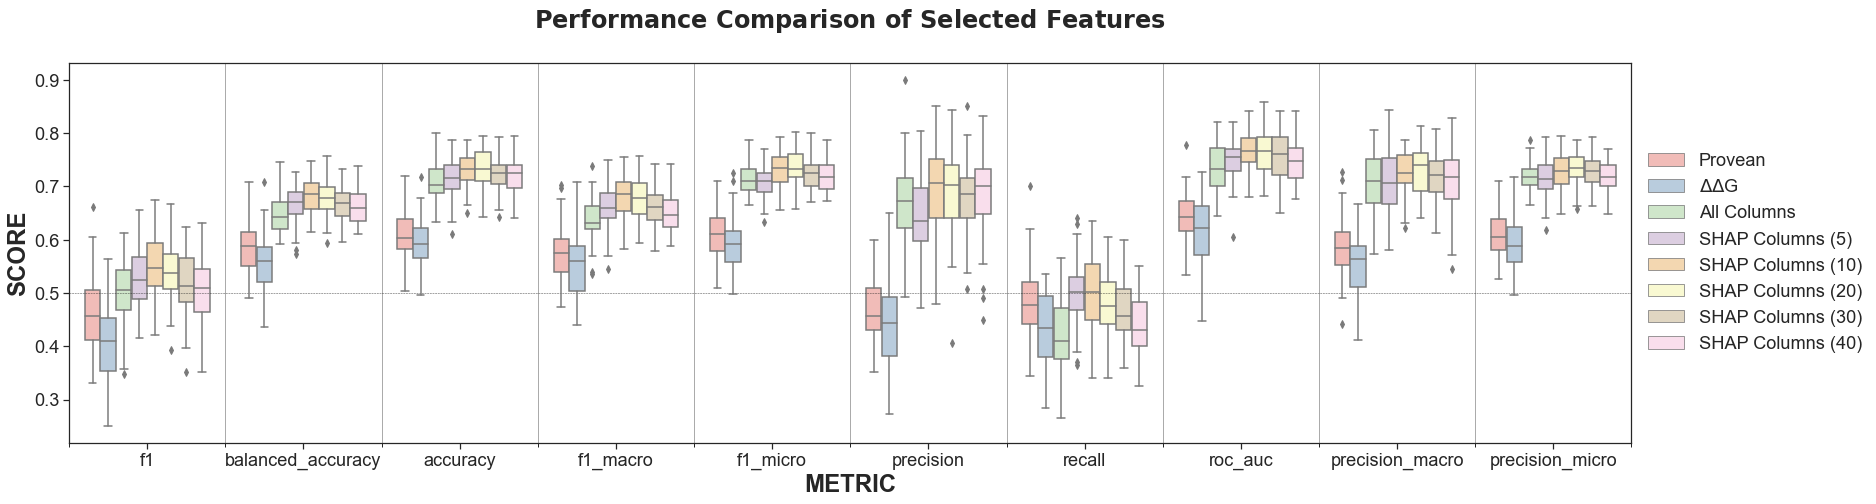

In [33]:
predator.eval_metrics.plot_performance_comparison_results()

## Fine Tuning

Fine Tuning on 80% of data (training *set*)

In [32]:
determined_feature_set = "shap_10"
predator.set_determined_feature_set(determined_feature_set)

2021-10-15 23:06:33 | DEBUG    | Predator | Setting determined feature set to `shap_10`.
2021-10-15 23:06:33 | DEBUG    | Predator | Setting determined features to 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score'].


In [33]:
predator.run_hyperparameter_search(
    n_iter=20,
    n_repeats_cv=3,
    n_jobs=4,
    verbose=0,
    search_type="randomized",
    param_grid_level=0
)

2021-10-15 23:06:45 | DEBUG    | helpers.helpers_predator.fine_tuning | Running randomized search for each experiment ..
2021-10-15 23:06:45 | DEBUG    | helpers.helpers_predator.fine_tuning | PARAM_GRID: {'max_depth': [2, 5, 10], 'n_estimators': [10, 25, 50, 75, 100, 200, 400], 'min_samples_split': [2, 5], 'max_features': ['auto', 'sqrt', None], 'class_weight': ['balanced', None]}


  0%|          | 0/50 [00:00<?, ?it/s]

In [34]:
predator.fine_tuner.classifiers_attributes_data.head()

,best_params_,best_estimator_,best_score_
EXP_1,"{'n_estimators': 50, 'min_samples_split': 5, '...","(DecisionTreeClassifier(max_depth=5, max_featu...",0.721991
EXP_2,"{'n_estimators': 50, 'min_samples_split': 2, '...","(DecisionTreeClassifier(max_depth=10, max_feat...",0.702778
EXP_3,"{'n_estimators': 25, 'min_samples_split': 2, '...","(DecisionTreeClassifier(max_depth=10, max_feat...",0.713565
EXP_4,"{'n_estimators': 100, 'min_samples_split': 5, ...","(DecisionTreeClassifier(max_depth=2, max_featu...",0.685046
EXP_5,"{'n_estimators': 100, 'min_samples_split': 5, ...","(DecisionTreeClassifier(max_depth=5, max_featu...",0.718843


In [35]:
predator.fine_tuner.best_estimators[:5]

[RandomForestClassifier(class_weight='balanced', max_depth=5,
                        min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=50,
                        random_state=2),
 RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=25,
                        random_state=3),
 RandomForestClassifier(class_weight='balanced', max_depth=2,
                        min_samples_split=5, random_state=4),
 RandomForestClassifier(class_weight='balanced', max_depth=5,
                        min_samples_split=5, random_state=5)]

In [36]:
len(predator.tuned_models)

50

In [37]:
predator.tuned_models[:5]

[RandomForestClassifier(class_weight='balanced', max_depth=5,
                        min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=50,
                        random_state=2),
 RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=25,
                        random_state=3),
 RandomForestClassifier(class_weight='balanced', max_depth=2,
                        min_samples_split=5, random_state=4),
 RandomForestClassifier(class_weight='balanced', max_depth=5,
                        min_samples_split=5, random_state=5)]

In [38]:
predator.fine_tuner.best_estimators[:5] == predator.tuned_models[:5]

True

In [39]:
predator.default_models[0]

RandomForestClassifier(random_state=42)

In [40]:
len(predator.tuned_models)

50

In [41]:
predator.tuned_models[0]

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=50, random_state=1)

In [42]:
predator.tuned_models[1]

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=50,
                       random_state=2)

## Performance of Tuned Models on (out of sample) Validation Data

For each experiment, the **hyper-tuned** models are fitted with 80% of training data and predictions are made for the remaining 20%. Then performance is evaluated comparing predictions with groundtruth labels.

In [43]:
predator.run_evaluate_valid(models_type='feature_selected')

2021-10-15 23:47:18 | DEBUG    | helpers.helpers_predator.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-10-15 23:47:18 | DEBUG    | helpers.helpers_predator.evaluation | Evaluating with default models using determined features.
2021-10-15 23:47:18 | DEBUG    | helpers.helpers_predator.evaluation | Determined features: 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.7576
Balanced accuracy score : 0.6845
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.7273
Balanced accuracy score : 0.6607
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.8485
Balanced accuracy score : 0.7917
-------- EXPERIMENT:  4 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(random_state=42)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7024
-------- EXPERIMENT:  5 --------
X_train.shape=(131, 10), y_trai

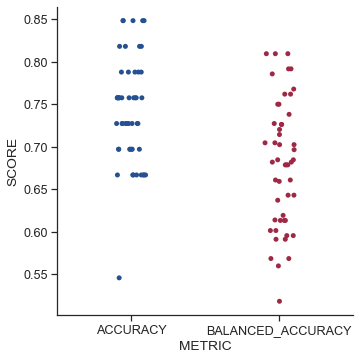

In [44]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["feature_selected_scoring"]["acc_scores"], 
    predator.eval_valid.scores["feature_selected_scoring"]["balan_acc_scores"],
    kind='strip'
)

In [45]:
predator.run_evaluate_valid(models_type='tuned')

2021-10-15 23:47:28 | DEBUG    | helpers.helpers_predator.evaluation | Training on train set and measuring performance by predicting on validation set.
2021-10-15 23:47:28 | DEBUG    | helpers.helpers_predator.evaluation | Evaluating with tuned models.
2021-10-15 23:47:28 | DEBUG    | helpers.helpers_predator.evaluation | Determined features: 
['Provean_score', 'EL2_score', 'Final_ddG', 'Interactor_alignment_score', 'Matrix_score', 'Solvent_accessibility_wt', 'Solvent_accessibility_mut', 'van_der_waals_mut', 'Interactor_template_sequence_identity', 'Model/DOPE_score']


  0%|          | 0/50 [00:00<?, ?it/s]

-------- EXPERIMENT:  1 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=50, random_state=1)
Accuracy score		: 0.7576
Balanced accuracy score : 0.6845
-------- EXPERIMENT:  2 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=50,
                       random_state=2)
Accuracy score		: 0.7273
Balanced accuracy score : 0.6607
-------- EXPERIMENT:  3 --------
X_train.shape=(131, 10), y_train.shape=(131,), X_valid.shape=(33, 10), y_valid.shape=(33,)
Classifier: RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=25,
                       random_state=3)
Accuracy score		: 0.7576
Balanced accuracy score : 0.7202
-------- EXPERIMENT:  4 --------
X_train.shape=(131,

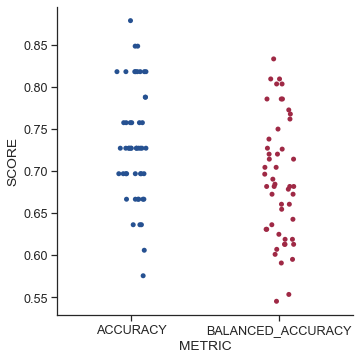

In [46]:
visualize_accuracy_metrics(
    predator.eval_valid.scores["finalized_scoring"]["acc_scores"], 
    predator.eval_valid.scores["finalized_scoring"]["balan_acc_scores"],
    kind='strip'
)

,Experiment,Acc_scores,Balan_acc_scores,Models_type
0,0,0.757576,0.684524,Tuned+FeatureSelected
1,1,0.727273,0.660714,Tuned+FeatureSelected
2,2,0.757576,0.720238,Tuned+FeatureSelected
3,3,0.818182,0.785714,Tuned+FeatureSelected
4,4,0.787879,0.726190,Tuned+FeatureSelected
5,5,0.818182,0.785714,Tuned+FeatureSelected
6,6,0.848485,0.809524,Tuned+FeatureSelected
7,7,0.727273,0.681818,Tuned+FeatureSelected
8,8,0.575758,0.545455,Tuned+FeatureSelected
9,9,0.696970,0.672619,Tuned+FeatureSelected


       Experiment  Acc_scores  Balan_acc_scores
count    50.00000   50.000000         50.000000
mean     24.50000    0.732727          0.689491
std      14.57738    0.067257          0.071955
min       0.00000    0.575758          0.545455
25%      12.25000    0.696970          0.630952
50%      24.50000    0.727273          0.681818
75%      36.75000    0.780303          0.735390
max      49.00000    0.878788          0.833333
2021-10-15 23:47:39 | INFO     | helpers.helpers_predator.evaluation | balanced_acc_threshold: 0.6309523809523809
2021-10-15 23:47:39 | INFO     | helpers.helpers_predator.evaluation | bad_models_ix: [8, 10, 14, 18, 23, 28, 35, 37, 40, 46, 48, 49]
2021-10-15 23:47:39 | INFO     | helpers.helpers_predator.evaluation | qualified_models_ix: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 38, 39, 41, 42, 43, 44, 45, 47]
                                 Number of Model
Tuned+FeatureSelected              

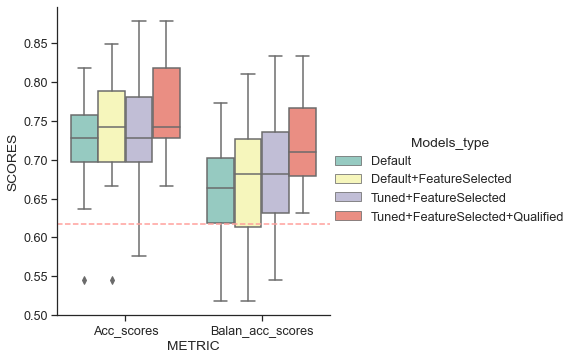

In [47]:
predator.compare_tuned_models(kind='box')

,Experiment,Acc_scores,Balan_acc_scores,Models_type
0,0,0.757576,0.702381,Tuned+FeatureSelected
1,1,0.696970,0.672619,Tuned+FeatureSelected
2,2,0.757576,0.720238,Tuned+FeatureSelected
3,3,0.878788,0.833333,Tuned+FeatureSelected
4,4,0.787879,0.726190,Tuned+FeatureSelected
5,5,0.787879,0.708333,Tuned+FeatureSelected
6,6,0.818182,0.750000,Tuned+FeatureSelected
7,7,0.787879,0.704545,Tuned+FeatureSelected
8,8,0.636364,0.568182,Tuned+FeatureSelected
9,9,0.727273,0.714286,Tuned+FeatureSelected


       Experiment  Acc_scores  Balan_acc_scores
count    50.00000   50.000000         50.000000
mean     24.50000    0.740606          0.683885
std      14.57738    0.069307          0.082390
min       0.00000    0.636364          0.535714
25%      12.25000    0.674242          0.617560
50%      24.50000    0.742424          0.692100
75%      36.75000    0.787879          0.748512
max      49.00000    0.878788          0.851190
2021-10-10 20:00:56 | INFO     | helpers.helpers_predator.evaluation | balanced_acc_threshold: 0.6175595238095238
2021-10-10 20:00:56 | INFO     | helpers.helpers_predator.evaluation | bad_models_ix: [8, 10, 13, 14, 15, 18, 33, 37, 40, 41, 44, 46, 48]
2021-10-10 20:00:56 | INFO     | helpers.helpers_predator.evaluation | qualified_models_ix: [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39, 42, 43, 45, 47, 49]
                                 Number of Model
Default                            

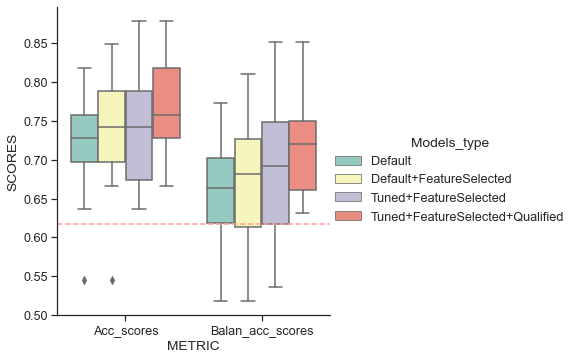

In [49]:
predator.compare_tuned_models(kind='box')

In [48]:
predator.eval_valid.comparison_data

Models_type,Default,Default+FeatureSelected,Tuned+FeatureSelected,Tuned+FeatureSelected+Qualified
Acc_scores,0.728485,0.741818,0.732727,0.756778
Balan_acc_scores,0.663214,0.679675,0.689491,0.717860


In [49]:
print(len(predator.default_models))
pprint(predator.default_models[:3])
print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  ')
print(len(predator.tuned_models))
pprint(predator.tuned_models[:3])
print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  ')
print(len(predator.qualified_models))
pprint(predator.qualified_models[:3])

50
[RandomForestClassifier(random_state=42),
 RandomForestClassifier(random_state=42),
 RandomForestClassifier(random_state=42)]
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
50
[RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=50,
                       random_state=2),
 RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=25,
                       random_state=3)]
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  
38
[RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_split=5, n_estimators=50, random_state=1),
 RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=50,
                       random_state=2),
 RandomForestClassifier(max_depth=10, max_features='sqrt', n_estima

In [50]:
print(len(predator.qualified_models))
predator.qualified_models == predator.eval_valid.qualified_models

38


True

## Fit Finalized Models

For each experiment, the **hyper-tuned** models are fitted with **all of training** data. These models then will be used to make prediction on TCGA Cancer Datasets.

In [51]:
predator.fit_finalized_models()

2021-10-15 23:48:55 | DEBUG    | Predator | Fitting finalized models with all training data ..
2021-10-15 23:48:55 | INFO     | Predator | Model elimination: True
2021-10-15 23:48:55 | INFO     | Predator | Using 38 qualified models as finalized models.


  0%|          | 0/38 [00:00<?, ?it/s]

In [52]:
print(predator.n_experiment)
print(predator.n_models)

50
38


In [53]:
predator.data_materials.keys()

dict_keys(['train_data', 'train_data_processed', 'sampled_train_data_list', 'prepared_dataframes', 'label_proportions_dataframes', 'Xs', 'ys', 'Xs_train', 'ys_train', 'Xs_valid', 'ys_valid', 'Xs_train_random', 'ys_train_random', 'Xs_valid_random', 'ys_valid_random', 'Xs_shap_5', 'Xs_train_shap_5', 'Xs_valid_shap_5', 'Xs_provean', 'Xs_train_provean', 'Xs_ddG', 'Xs_train_ddG', 'Xs_shap_10', 'Xs_train_shap_10', 'Xs_valid_shap_10', 'Xs_shap_20', 'Xs_train_shap_20', 'Xs_valid_shap_20', 'Xs_shap_30', 'Xs_train_shap_30', 'Xs_valid_shap_30', 'Xs_shap_40', 'Xs_train_shap_40', 'Xs_valid_shap_40'])

## Exporting Model

In [54]:
from helpers.helpers_predator.common import export_serialized_predator

In [55]:
export_serialized_predator(predator)

2021-10-15 23:49:10 | DEBUG    | helpers.helpers_predator.common | Folder with ID d85a4ed3 is created.
2021-10-15 23:49:10 | DEBUG    | helpers.helpers_predator.common | Exporting Predator at location PredatorModels in folder PredatorModel_2021-10-15\d85a4ed3..
2021-10-15 23:49:11 | INFO     | helpers.helpers_predator.common | Predator object PredatorModels\PredatorModel_2021-10-15\d85a4ed3\predator.pkl is exported.
2021-10-15 23:49:11 | INFO     | helpers.helpers_predator.common | Config is exported.


## Loading the model

In [56]:
from helpers.helpers_predator.common import load_predator
from helpers.helpers_predator.common import compare_predator_objects

In [59]:
PREDATOR_PATH = "PredatorModels/PredatorModel_2021-10-15/d85a4ed3/predator.pkl"

In [60]:
predator_loaded = load_predator(PREDATOR_PATH)

2021-10-15 23:50:04 | INFO     | helpers.helpers_predator.common | Predator object PredatorModels/PredatorModel_2021-10-15/d85a4ed3/predator.pkl is loaded successfully.


In [61]:
compare_predator_objects(predator, predator_loaded)

2021-10-15 23:50:06 | DEBUG    | helpers.helpers_predator.common | Checking attribute n_experiment ..
2021-10-15 23:50:06 | DEBUG    | helpers.helpers_predator.common | Checking attribute n_models ..
2021-10-15 23:50:06 | DEBUG    | helpers.helpers_predator.common | Checking attribute random_seeds ..
2021-10-15 23:50:06 | DEBUG    | helpers.helpers_predator.common | Checking attribute paths ..
2021-10-15 23:50:06 | DEBUG    | helpers.helpers_predator.common | Checking attribute tcga_cohorts ..
2021-10-15 23:50:06 | DEBUG    | helpers.helpers_predator.common | Checking attribute data_materials ..
2021-10-15 23:50:07 | DEBUG    | helpers.helpers_predator.common | Checking attribute default_models ..
2021-10-15 23:50:07 | DEBUG    | helpers.helpers_predator.common | Checking attribute tuned_models ..
2021-10-15 23:50:07 | DEBUG    | helpers.helpers_predator.common | Checking attribute finalized_models ..
2021-10-15 23:50:07 | DEBUG    | helpers.helpers_predator.common | Checking attribute

In [129]:
len(sorted(predator.data_materials["train_data_processed"]["UniProt_ID"].unique()))

164

In [128]:
sorted(predator.data_materials["train_data_processed"]["UniProt_ID"].unique())

['A5PKW4',
 'O00267',
 'O00311',
 'O14641',
 'O14788',
 'O14796',
 'O14893',
 'O14965',
 'O14980',
 'O15085',
 'O15111',
 'O43521-3',
 'O43541',
 'O43543',
 'O43617',
 'O43809',
 'O75771',
 'O95149',
 'O95405',
 'P00492',
 'P00533',
 'P01100',
 'P01112',
 'P01116',
 'P01116-2',
 'P01133',
 'P01270',
 'P01903',
 'P02489',
 'P02538',
 'P02671',
 'P04049',
 'P04637',
 'P07195',
 'P10276',
 'P11362',
 'P11802',
 'P11940',
 'P12272',
 'P13489',
 'P13501',
 'P13646',
 'P13747',
 'P15056',
 'P16144',
 'P16220',
 'P19429',
 'P21860',
 'P21912',
 'P23297',
 'P25815',
 'P26715',
 'P30622-2',
 'P35908',
 'P38919',
 'P40337',
 'P40692',
 'P42771',
 'P42773',
 'P46527',
 'P46734',
 'P48059',
 'P50616',
 'P51587',
 'P51809',
 'P52294',
 'P52298',
 'P54198',
 'P54727',
 'P55211',
 'P55957',
 'P56945',
 'P60891',
 'P61081',
 'P61224',
 'P61326',
 'P61587',
 'P62195',
 'P62805',
 'P63000',
 'P63272',
 'P63279',
 'P68431',
 'P84022',
 'P84077',
 'P84243',
 'Q00534',
 'Q00987',
 'Q07812',
 'Q07820',
 'Q0